# APPM 5720 DeepGreen Example Notebook
#### Paper: DeepGreen: deep learning of Green’s functions for nonlinear boundary value problems
#### Paper by: Craig R. Gin, Daniel E. Shea, Steven L. Brunton, and J. Nathan Kutz
#### Notebook by: Rey Koki and Mike McCabe

This notebook walks through the nonlinear Poisson problem from _DeepGreen_. Several steps are slightly simplified from the original code, which can be found here: https://github.com/sheadan/DeepGreen, since we're only implementing one example and do not need the fully general code. We also make a few small departures for efficiency/speed purposes. These will be pointed out when they come up.

## Nonlinear Poisson

Put the problem description here!

In [1]:
# Imports!
import numpy as np
import jax
import jax.random as rnd
import jax.numpy as jnp
import optax
import flax.linen as nn
import functools
import matplotlib.pyplot as plt
from flax.training import train_state
from flax.metrics import tensorboard
from random import shuffle
from typing import Sequence, Callable, Any, Optional, Dict
from jax.lib import xla_bridge
print('Device used', xla_bridge.get_backend().platform)

Device used gpu


## Defining the Neural Network

Here we define the neural network. Here, we use the Flax library built on top of JAX. JAX is an automatic differentiation and linear algebra acceleration library developed by Google. The API is intended to mimic numpy, though it has the added capability for functional transformations like computing gradients, automatically vectorizing code, or just-in-time (JIT) compiling it down to XLA code.

Flax tends to have quite a bit of complexity hidden behind the scenes which makes it a bit harder to use than comparable libraries like PyTorch. Looking through the code below, it might seem like some things are being instantiated every time the model is called, but in practice, these objects are traced when they are instantiated and the actual object being behaves slightly differently. 

The model itself consists of two sets of encoders/decoders with the linear operator acting as a coupling mechanism in the encoding space. We start off by defining the Encoder and Decoder templates:

__We didn't directly parameterize the encoder/decoders in DeepGreen for this demo, so to adjust the layers/depth/activations you'll have to do it directly (or adjust the code to pass parameters to the inner modules. If you adjust the layer count, you also need to adjust the downsampling factor in GreenNet to use custom resolutions (values of n).__

In [2]:
class Conv2DEncoder(nn.Module):
    # This is a DataClass, so these implicitly define init parameters
    num_filters: Sequence[int] = (8, 16, 32, 64)
    conv_window: Sequence[int] = (4, 4)
    conv_strides: int = (1,1)
    conv_padding: str = 'SAME'
    pool_window: Sequence[int] = (2, 2)
    pool_strides: int = (2,2)
    pool_padding: str = 'VALID'
    act_fn: Callable = nn.relu
    add_init_fin: bool = True
        
    @nn.compact
    def __call__(self, x):
        inputs = x[:] # Save copy of inputs for residual        
        for i, filters in enumerate(self.num_filters):
            if i > 0:
                x = nn.avg_pool(x, window_shape=self.pool_window,
                                strides=self.pool_strides,
                               padding=self.pool_padding)
            x = nn.Conv(features=filters, kernel_size=self.conv_window,
                       strides=self.conv_strides, padding=self.conv_padding)(x)
            x = self.act_fn(x)
            # If residual included, add projected inputs
        if self.add_init_fin:
            inputs = nn.Conv(features=self.num_filters[-1], 
                        kernel_size=(2**(len(self.num_filters)-1),)*2,
                         strides=(2**(len(self.num_filters)-1),)*2,
                        padding='VALID')(inputs)

            x += inputs
        return x.reshape(x.shape[0], -1)
                
    
class Conv2DDecoder(nn.Module):
    init_size: Sequence[int] = (16, 16, 64)
    output_size: Sequence[int] = (-1, 128, 128)
    num_filters: Sequence[int] = (32, 16, 8)
    conv_window: Sequence[int] = (4, 4)
    conv_strides:int = (2,2)
    conv_padding: str = 'SAME'
    act_fn: Callable = nn.relu
    add_init_fin: bool = True
        
    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, *self.init_size)
        inputs = x[:]
        for filters in self.num_filters:
            x = nn.ConvTranspose(features=filters, kernel_size=self.conv_window,
                                 strides=self.conv_strides, padding=self.conv_padding)(x)
            x = self.act_fn(x)
        # Do one last small convolution
        x = nn.ConvTranspose(features=1,
                             kernel_size=self.conv_window,
                            strides=(1,1),
                            padding=self.conv_padding)(x).squeeze(-1)
        
        # Note this a departure from the actual paper code
        # which just reshapes the encoder space to add. Since
        # that makes no sense (it's like trying to add a smaller color
        # image to a larger greyscale image by shifting the RGB values to different
        # pixels to make the shapes line up), we've swapped to standard upsampling
        if self.add_init_fin:
            inputs = nn.Conv(features=1, kernel_size=(1, 1))(inputs).squeeze(-1)
            inputs = jax.image.resize(inputs, shape=(inputs.shape[0], *self.output_size[1:]), method='linear')
            x += inputs
        return x

Once the encoders and decoders are built, the full model just connects the encoder/decoder pairs through a few linear projections and the linear operator. The sequential linear operations are a little unconventional as these are essentially a single low-rank linear operator though with the coupling $Lv=f$/$L^{-1}f=v$ promoted by the loss function.

Note that we return all values included in loss functions. In applications, one would likely only be using the trained model to infer $u$ from $f$ and as such would not require all outputs.

In [3]:
class GreenNet(nn.Module):
    # Note, since we're only doing the nonlinear Poisson example,
    # we removed some of the parameterization here to simplify things
    n: int = 128
    units_latent: int = 200    
    
    @nn.compact
    def __call__(self, inputs):
        u, F = inputs
        
        # Let's define our modules. Since we reuse them, it probably would have
        # made more sense to not use nn.compact and just use a setup function
        # but it is too late now. This is getting traced anyway,
        # so it doesn't actually matter apart from looking a bit clunky.
        u_encoder = Conv2DEncoder()
        u_decoder = Conv2DDecoder(output_size=(-1, self.n, self.n), init_size=(self.n//8, self.n//8, 64))
        v_reducer = nn.Dense(self.units_latent)
        v_expander = nn.Dense(self.n**2)
        
        F_encoder = Conv2DEncoder()
        F_decoder = Conv2DDecoder(output_size=(-1, self.n, self.n), init_size=(self.n//8, self.n//8, 64))
        f_reducer = nn.Dense(self.units_latent)
        f_expander = nn.Dense(self.n**2)
        
        operator = self.param('Operator', init_fn=lambda key: jnp.eye(self.units_latent)*1.)

        # Autoencode u
        u_encoded = u_encoder(u)
        # I guess this avoids doing a large dense matrix inverse
        v = v_reducer(u_encoded)
        v_exp = v_expander(v)
        u_decoded = u_decoder(v_exp)
        
        # Autoencode F
        F_encoded = F_encoder(F)
        f = f_reducer(F_encoded)
        f_exp = f_expander(f)
        F_decoded = F_decoder(f_exp)  
        
        # L things - seems kind of wasteful, but L is small
        L_upper = jnp.triu(operator)
        L = .5*(L_upper+L_upper.T)
        
        # Forward model
        Lv = jax.lax.dot_general(v, L,
                                 (((v.ndim - 1,), (0,)), ((), ())),)
        Lv_exp = f_expander(Lv)
        Lv_decoded = F_decoder(Lv_exp)
        
        # Inverse model
        Linvf = jnp.linalg.solve(jnp.expand_dims(L, 0), f)
        Linvf_exp = f_expander(Linvf)
        Linvf_decoded = F_decoder(Linvf_exp)
        
        return u_decoded, F_decoded, Lv_decoded, Linvf_decoded, f, v, Lv

## Building the data set

We handle data a bit differently from the paper to avoid forcing everyone to download several GB of data. The paper generated data by sampling forcing functions and using an external solver to generate solutions. This is time consuming and doesn't actually compute the exact loss. We instead use the Method of Manufactured Solutions (MMS) so that we can generate solutions and forcings in real time.

As opposed to computing true solutions for given forcings, in MMS, you sample solutions and compute the forcing by applying the differential operator to the solution. While this doesn't always result in realistic problems and generally requires smooth solutions, it is much, much faster and more accurate than generating data from numerical solvers. The downside is that using their forcings as solutions breaks boundary conditions which isn't ideal given the proposal is to learn a Green's function in the encoder space, so we changed some of the functions up to ensure homogeneous BCs. 

This data API here is a little weird - the original version was too slow for demo purposes, so the final version is a mix between the original version (which used a more standard data API) and a JIT-friendly data API. The test/train split components are the main victims here as they ultimately got hard-coded with some unnecessary storage.

In [4]:
from itertools import product

def nlp_operator(u):
    """ Transforms function by applying the nonlinear Poisson operator:
      
        Pu = -\nabla \dot ((1+u^2)\nabla u)
    """
    flux = lambda x: (1+u(x)**2)*(jax.grad(u)(x))
    return lambda x: (-jax.jacfwd(flux)(x)*jnp.eye(2)).sum()
    
def jax_collate(batch):
    if isinstance(batch[0], jnp.DeviceArray):
        return jnp.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [jax_collate(samples) for samples in transposed]
    else:
        return jnp.array(batch)
    
def NLP_Dataset_Sampler(n=128, batch_size=64, cubic=False, train=True, valid=False, test=False):
    """ Factory for building data samplers for training.
    
    Parameters
    -----------
    n ~ int: Number of grid points in the x and y directions
    batch size ~ int: Examples per batch.
    cubic ~ bool: Indicator whether to sample from the cubic space
    train ~ bool: Indicator whether to use the train indices
    valid ~ bool: Indicator whether to use the validation indices
    test ~ bool: Indicator whether to use the (non-cubic) test indices
    
    Returns
    --------
    sampler ~ Callable: takes in indices and returns data
    len_func ~ Callable: zero parameter function that returns the dataset size.
    """
    ##### u, F Builder Functions ######
    def gamma(k):
        return .01 +.28*k/3
              
    def build_gaussian(params):
        # Just multiplied by sin to get BCs
        a, bx, by, c = params
        u = lambda x: .01*a*jnp.exp((-(x[0]-bx)**2 - (x[1]-by)**2)/(2*c**2))*jnp.sin(.5*x[0])*jnp.sin(.5*x[1])
        F = nlp_operator(u)
        Um, Fm = jax.vmap(u), jax.vmap(F)
        return Um(coords), Fm(coords)
    
    def build_cosine(params):
        # Actually sines
        alpha, betax, betay, _ = params 
        u = lambda x: .01*alpha*jnp.sin(betax*x[0])*jnp.sin(betay*x[1])
        F = nlp_operator(u)
        Um, Fm = jax.vmap(u), jax.vmap(F)
        return Um(coords), Fm(coords)
    
    
    def build_cubic1(params):
        # Moved 0s
        kx, ky, _, _ = params
        u = lambda x: .01*(kx*(x[0]-jnp.pi)*(x[0]-2*jnp.pi)*x[0] \
                        + ky*(x[1]-jnp.pi)*(x[1]-2*jnp.pi)*x[1])
        F = nlp_operator(u)
        Um, Fm = jax.vmap(u), jax.vmap(F)
        return Um(coords), Fm(coords)
    
    def build_cubic2(params):
        # Moved 0s and removed psi
        kx, ky, zetax, zetay = params
        u = lambda x: .01*(kx*(x[0]-jnp.pi)*(x[0]-2*jnp.pi)*x[0] + ky*(x[1]-jnp.pi)*(x[1]-2*jnp.pi)*x[1] \
                        + zetax*(x[0]-2*jnp.pi)*x[0] + zetay*(x[1]-2*jnp.pi)*x[1])
        F = nlp_operator(u)
        Um, Fm = jax.vmap(u), jax.vmap(F)
        return Um(coords), Fm(coords)

    ##### Actual Sampling functions #####
    def get_len():
        return len(data)
    
    def get_item(idx):
        sub = data[idx]
        func_build, params = sub[0], sub[1:]
        u, F = jax.lax.switch(func_build.astype(int), [build_gaussian, build_cosine,
                                                      build_cubic1, build_cubic2], params) 
        return u.reshape(n, n, 1), F.reshape(n, n, 1)
    
    sample = jax.vmap(get_item)
    
    # Build shared state for all inner functions
    if not cubic:
        # Set up Gaussians
        a_range = jnp.arange(-25, 26., 5)
        b_range = jnp.arange(jnp.pi/3, 5*jnp.pi/3+.01, jnp.pi/3)
        c_range = jnp.arange(.1, 5, .2)
        gauss_params = [(0.,)+ p for p in product(a_range, b_range, b_range, c_range)]

        alpha_range = jnp.arange(1, 10.1, .1)
        beta_range = jnp.arange(1, 5.1, .5)
        cosine_params = [(1.,)+ p+(0,) 
                         for p in product(alpha_range, beta_range, beta_range)]

        total_params = gauss_params + cosine_params
        shuffle(total_params)

        # Hard coding the values from the paper even though it's not the same
        if train:
            data = total_params[:9806]
        elif valid:
            data = total_params[9806:9806+2452]
        else:
            data = total_params[9806+2452:]

    else:
        k = gamma(jnp.array([0, 1, 2, 3]))
#         psi = jnp.arange(-5, 6., 1)
        zeta = jnp.arange(.01, .26, .6)
        cubic1_params = [(2.,) + p+(0,0)
                       for p in product(k, k)]
        cubic2_params = [(3.,) + p
                       for p in product(k, k, zeta, zeta)]
        data = cubic1_params + cubic2_params

    data = jnp.array(data)
    # Build the mesh once and reuse
    xx, yy = jnp.meshgrid(jnp.linspace(0, 2*jnp.pi, n), jnp.linspace(0, 2*jnp.pi, n))
    coords = jnp.stack([xx, yy], -1).reshape(-1, 2)
    
    return jax.jit(sample), get_len

## Setting up the run

Now we'll define the training loops. The paper uses multiple parallel runs and takes the best performing models. This is going to be running on Colab so you are not going to have the hardware for that. Instead, we're just going to train a single model.

In [33]:
@jax.jit
def update_params(state, grads):
    return state.apply_gradients(grads=grads)

        
@jax.jit
def compute_losses(u, F, u_decoded, F_decoded, Lv_decoded, Linvf_decoded, f, v, Lv, eps=1e-5):
    """ Computes the 6 Normalized MSEs from the paper.
    
    Note: the use of means instead of sums in computing squared norms is from the paper
    code. They also sum over batches. This doesn't matter that much, but it does adjust the weighting a bit, 
    so we manually re-weight to account for it.
    """
    # Loss 1 - Reconstruction u
    loss1 = (((u_decoded - u)**2).mean((1, 2)) / ((u**2).mean((1,2))+eps)).mean()
    # Loss 2 - Reconstruction f 
    loss2 = (((F_decoded - F)**2).mean((1, 2)) / ((F**2).mean((1,2))+eps)).mean()
    # Loss 3 - Forward in encoded space - don't love the gradient dynamics of dividing here
    loss3 = (((Lv - f)**2).mean(-1) / ((f**2).mean(-1)+eps)).mean()
    # Loss 4 - "Superposition" loss - seems like it would just change the relative weight of loss 3 
    # in a weird non-convex way and penalize the magnitude of the encoded vectors. Doesn't seem like 
    # a great idea, but it is in the paper
    loss4 = 0.
    # Loss 5 - Forward operator loss
    loss5 = (((Lv_decoded - F)**2).mean((1, 2)) / ((F**2).mean((1,2))+eps)).mean()
    # Loss 6 - Backwards operator loss
    loss6 = (((Linvf_decoded - u)**2).mean((1, 2)) / ((u**2).mean((1,2))+eps)).mean()
    return loss1, loss2, loss3, loss4, loss5, loss6

@functools.partial(jax.jit, static_argnums=(0, 2, 4, 5))
def train_epoch(model, state, data, perms, num_batches, eval_full=True):
    # JIT is touchy around conditionals (the trace notes the first path), so this just says compile
    #  again if the conditional changes. 
    @functools.partial(jax.jit)
    def grad_step(state, perm):
        def loss_fn(params):
            # Run model
            u_decoded, F_decoded, Lv_decoded, Linvf_decoded, f, v, Lv = model.apply({'params':params}, batch)
            u, F = batch
            u, F = u.squeeze(-1), F.squeeze(-1)
            loss1, loss2, loss3, loss4, loss5, loss6 = compute_losses(u, F, u_decoded, F_decoded, 
                                                                      Lv_decoded, Linvf_decoded, f, v, Lv)
            # We're keeping all the losses for logging, but the total loss is only the reconstruction
            # losses at the beginning of training
            if eval_full:
                return loss1+loss2+loss3+loss4+loss5+loss6, (loss1, loss2, loss3, loss4, loss5, loss6)
            else:
                return loss1+loss2, (loss1, loss2, loss3, loss4, loss5, loss6)
        
        batch = data(perm)
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (train_loss, aux_losses), grads = grad_fn(state.params)
        state = update_params(state, grads)
        return state, aux_losses

    # Run actual code - Carries and updates state every batch
    # returns final state and accumulated outputs (losses)
    state, aux_loss_means = jax.lax.scan(grad_step, state, perms)
    return state, [jnp.mean(l) for l in aux_loss_means]   

def validation_run(model, state, data, batch_size, num_batches):
    # Only difference is we do not compute the gradient and update the state here
    @functools.partial(jax.jit)
    def exec_step(state, perm):
        # Run model
        batch = data(perm)
        u_decoded, F_decoded, Lv_decoded, Linvf_decoded, f, v, Lv = model.apply({'params':state.params}, batch)
        u, F = batch
        u, F = u.squeeze(-1), F.squeeze(-1)
        loss1, loss2, loss3, loss4, loss5, loss6 = compute_losses(u, F, u_decoded, F_decoded, 
                                                                  Lv_decoded, Linvf_decoded, f, v, Lv)        
        return state, (loss1, loss2, loss3, loss4, loss5, loss6)
    perms = jnp.arange(batch_size*num_batches).reshape(num_batches, batch_size)
    state, aux_loss_means = jax.lax.scan(exec_step, state, perms)
    return aux_loss_means
        

In [34]:
# Model run parameters
aec_only_epochs = 75
full_epochs = 2500
batch_size = 64
n= 32

# Content doesn't matter so we're just chosing a convenient shape
init_vals = jnp.array(np.random.uniform(size=(10, n, n, 1)))

# JAX's random is kind of a pain, but it makes more sense when you're doing distributed training
# which we are not doing here. 
key = rnd.PRNGKey(0)
key, use_key = rnd.split(key, 2)

model = GreenNet(n=n)
params = model.init(use_key, (init_vals, init_vals))

# JAX is a functional framework, but Deep Learning has historically used mostly object oriented libraries.
# TrainState is a helper for organizing the model parameters and state so the training loop can be written 
# more like OOP code.

# We're using the AdamW optimizer as the paper uses Adam with weight decay. 
state = train_state.TrainState.create(apply_fn=model.apply,
                                     params = params['params'],
                                     tx=optax.adamw(learning_rate=1e-3, weight_decay=1e-6))

# Load up on datasets - the len funcs instead of objects were just a mistake
train_dataset, train_len_func = NLP_Dataset_Sampler(n=n, batch_size=batch_size)
valid_dataset, valid_len_func = NLP_Dataset_Sampler(n=n, batch_size=batch_size, train=False, test=True)
test_dataset, test_len_func = NLP_Dataset_Sampler(n=n, batch_size=batch_size, train=False, test=True)
cubic_test_dataset, cubic_len_func = NLP_Dataset_Sampler(n=n, batch_size=batch_size, cubic=True)

Before we train the model, let's look in at what functions we're trying to learn:

<Figure size 432x432 with 0 Axes>

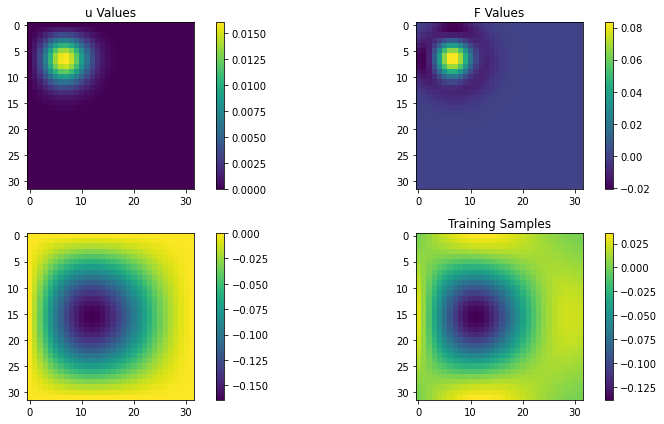

In [35]:
u, F = train_dataset(jnp.array([1, 11]))

fig = plt.figure(constrained_layout=True, figsize=(6,6))
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0][0].set_title('u Values')
axes[0][1].set_title('F Values')
aa = axes[0][0].imshow(u[0])
plt.colorbar(aa, ax=axes[0][0])
ab = axes[0][1].imshow(F[0])
plt.colorbar(ab, ax=axes[0][1])
ac = axes[1][0].imshow(u[1])
plt.colorbar(ac, ax=axes[1][0])
ad = axes[1][1].imshow(F[1])
plt.colorbar(ad, ax=axes[1][1])
plt.title('Training Samples')
plt.tight_layout()

These functions seem a bit harder due to varying scales compared to the paper problems, which from observing their "hardest" problems by loss, seemed to have generally had forcings and solutions on the same scale. In our case, there might be several orders of magnitude difference between the two. This makes the optimization problem a bit harder as we'd like all of our losses to have similar magnitude, but that's not going to be possible here without careful reweighting. We had to manually scale them down to reduce the magnitude gaps within individual solutions and forcings.

## Running the Model

Now all that's left is training the model. On the colab GPU with $n=128$ (the setting from the paper), this will take far longer than this class. You can either reduce the size (make sure it's a multiple of 16) or try training and skip ahead to the next section where you can use a pre-trained model.

In [36]:
%load_ext tensorboard
%tensorboard --logdir=.

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22907), started 0:19:04 ago. (Use '!kill 22907' to kill it.)

In [37]:
## Train housekeeping
train_size = train_len_func()
n_batches = train_size // batch_size

#Validation housekeeping
valid_size = valid_len_func()
valid_bs = 512
valid_nbatches = valid_size // valid_bs

# General run things
summary_writer = tensorboard.SummaryWriter('.')
loss_names= ['L'+str(i) for i in range(1, 7)]
key = rnd.PRNGKey(0)

for i in range(full_epochs):
    # Run the training epoch
    key, use_key = rnd.split(key, 2)
    perm = rnd.permutation(use_key, train_size)[:batch_size*n_batches].reshape(n_batches, batch_size)
    state, train_loss = train_epoch(model, state, train_dataset, perm, n_batches, eval_full=i>aec_only_epochs)
    for j, loss in enumerate(train_loss):
        summary_writer.scalar('Train ' + loss_names[j], loss, i)
        
    # Check the validation set
    valid_losses = validation_run(model, state, valid_dataset, valid_bs, valid_nbatches)

    print(i, train_loss)
#     _, test_loss = validation_run(state, valid_dataset)

0 [DeviceArray(0.4261202, dtype=float32), DeviceArray(0.3129032, dtype=float32), DeviceArray(1.5759465, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0771992, dtype=float32), DeviceArray(161.54889, dtype=float32)]
1 [DeviceArray(0.03226293, dtype=float32), DeviceArray(0.04709037, dtype=float32), DeviceArray(1.605792, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0852604, dtype=float32), DeviceArray(268.3628, dtype=float32)]
2 [DeviceArray(0.01624302, dtype=float32), DeviceArray(0.03771617, dtype=float32), DeviceArray(1.5835305, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0706524, dtype=float32), DeviceArray(269.591, dtype=float32)]
3 [DeviceArray(0.01290627, dtype=float32), DeviceArray(0.02983182, dtype=float32), DeviceArray(1.6126096, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0740658, dtype=float32), DeviceArray(270.28397, dtype=float32)]
4 [DeviceArray(0.01386654, dtype=float32), DeviceArray(0.02854812, dtype=float

36 [DeviceArray(0.00313713, dtype=float32), DeviceArray(0.00430893, dtype=float32), DeviceArray(1.3039116, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0029007, dtype=float32), DeviceArray(316.4917, dtype=float32)]
37 [DeviceArray(0.00280259, dtype=float32), DeviceArray(0.0033919, dtype=float32), DeviceArray(1.3214304, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0023143, dtype=float32), DeviceArray(315.74054, dtype=float32)]
38 [DeviceArray(0.00386949, dtype=float32), DeviceArray(0.00312827, dtype=float32), DeviceArray(1.3926713, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0149574, dtype=float32), DeviceArray(315.4901, dtype=float32)]
39 [DeviceArray(0.00468943, dtype=float32), DeviceArray(0.00346468, dtype=float32), DeviceArray(1.5026493, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(1.0351148, dtype=float32), DeviceArray(315.0604, dtype=float32)]
40 [DeviceArray(0.00227367, dtype=float32), DeviceArray(0.0030922, dtype

KeyboardInterrupt: 

## Experimenting with Trained Model